# Lista 5 - Testes de Hipótese

## Testes A/B

Testes A/B são uma metodologia muito utilizada para detectarmos diferenças significativas entre dois grupos, geralmente chamados controle e teste. 

**Exemplo:** Há eficácia na prevenção de morte de uma determinada vacina contra a Covid? 

Para isso, teremos:
- Grupo de controle: placebo.
- Grupo de teste: vacina.

**Solução:** Realizamos amostragem bootstrap de cada grupo e plotamos boxplots das médias encontradas. No final comparamos as médias dos grupos para ver se há diferença significativa entre o número de mortos de cada grupo.

Vamos ver um exemplo prático de como realizar um teste A/B para dados reais.

Começamos importando a biblioteca pandas e carregando os dados do Enem2015. Em seguida, agrupamos pela variável 'DEPENDENCIA_ADMINISTRATIVA' para relembrarmos a distribuição dos dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.testing import assert_almost_equal
from numpy.testing import assert_equal
from numpy.testing import assert_array_almost_equal
from numpy.testing import assert_array_equal

In [2]:

url = 'https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/enem2015.csv'
data = pd.read_csv(url)

tmp = data.groupby('DEPENDENCIA_ADMINISTRATIVA').count()
tmp.head()

,NOTA_MEDIA_ESCOLA,TAXA_DE_APROVACAO,TAXA_DE_PARTICIPACAO
DEPENDENCIA_ADMINISTRATIVA,,,
Estadual,1054,1054,1054
Federal,43,42,43
Municipal,22,22,22
Privada,566,565,566


Imagine que queremos testar se existe diferença entre as médias da variável 'NOTA_MEDIA_ESCOLA' para escolas com 'DEPENDENCIA_ADMINISTRATIVA' Federal e Municipal. Matematicamente, queremos testar se:

 $$\mu_{Municipal} = \mu_{Federal},$$
 
 onde $\mu$ é a média da variável 'NOTA_MEDIA_ESCOLA'.

 Vamos utilizar os códigos da lista anterior e da aula de testes A/B como base para realização do *bootstrap*.

In [3]:
def bootstrap_mean(df1, df2, column, n=10000):
    size1 = len(df1)
    size2 = len(df2)
    values1 = np.zeros(n)
    values2 = np.zeros(n)
    values_diff = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size1, replace=True, random_state=i)
        sample2 = df2[column].sample(size2, replace=True, random_state=i*3)
        values1[i] = sample1.mean()
        values2[i] = sample2.mean()
        values_diff[i] = sample1.mean() - sample2.mean()
    return values1, values2, values_diff

federal = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Federal']
municipal = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Municipal']
col = 'NOTA_MEDIA_ESCOLA'
v_fed, v_mun, v_diff = bootstrap_mean(federal, municipal, col)

Em seguida plotamos os boxplots de cada grupo e avaliamos se há intersecção da amplitude dos valores para cada tipo de escola.

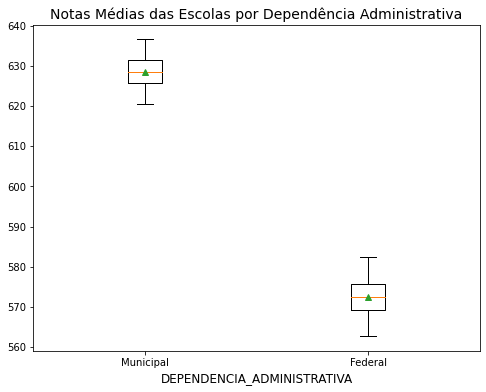

In [4]:
bp_data = [v_fed, v_mun]

plt.rcParams['figure.figsize']  = (8, 6)
plt.boxplot(bp_data, whis=[2.5, 97.5], positions=[1,2], showfliers=False, showmeans=True)
plt.xticks([1,2], ['Municipal', 'Federal'], fontsize=10)
plt.ylabel('', fontsize=13)
plt.xlabel('DEPENDENCIA_ADMINISTRATIVA', fontsize=12)
plt.title('Notas Médias das Escolas por Dependência Administrativa', fontsize=14)
plt.show()

Podemos observar que os boxplots não se cruzam, com evidência de que as médias das `NOTAS_MEDIA_ESCOLA` para escolas Federais são maiores que para escolas com `DEPENDENCIA_ADMINISTRATIVA` Municipal.

Outra maneira de realizarmos essa comparação entre as médias de dois grupos é computarmos a diferença entre as médias a cada amostragem *bootstrap* feita e analisarmos apenas o boxplot das diferenças. O código anterior computa essa diferença na variável `values` e o seguinte plota o boxplot de tais diferenças.

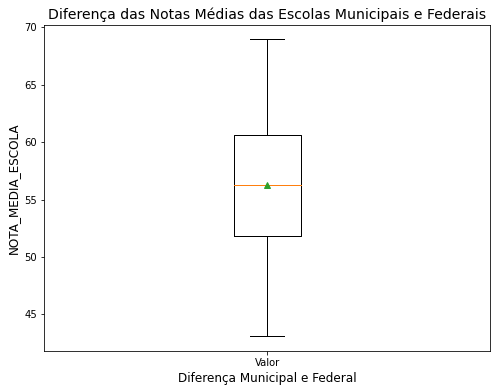

In [5]:
plt.rcParams['figure.figsize']  = (8, 6)

plt.boxplot(v_diff, whis=[2.5, 97.5], showfliers=False, showmeans=True)
plt.xticks([1], ['Valor'], fontsize=10)
plt.ylabel(col, fontsize=12)
plt.xlabel('Diferença Municipal e Federal', fontsize=12)
plt.title('Diferença das Notas Médias das Escolas Municipais e Federais', fontsize=14)
plt.show()

Nesse caso, para que as médias sejam consideradas iguais, analisamos se o *boxplot* gerado após o processo de amostragem, contém o valor 0. Como não é o caso, podemos afirmar que existem evidências de que as médias dos grupos comparados são distintas.

Note também, que alteramos o código do boxplot para que os limites sejam relativos aos percentis para um nível de 5% de significância, oque é um valor diferente de como é normalmente calculado os limites de um boxplot.

In [6]:
print('2.5% PERCENTIL: ', np.percentile(v_diff, 2.5).round(4))
print('97.5% PERCENTIL: ', np.percentile(v_diff, 97.5).round(4))

2.5% PERCENTIL:  43.1221
97.5% PERCENTIL:  68.9476


## Exercício 1

Altere o código abaixo para retornar `True` ou `False` ao comparar se há diferença para as medianas da variável `TAXA_DE_PARTICIPACAO` entre escolas de `DEPENDENCIA_ADMINISTRATIVA` indicadas, a dado nível de significância:

**Exemplo:** Se $\alpha = 0.05$, os percentis serão 2.5 e 97.5.

In [7]:
def percent(df1, df2, column, alpha):
  # deve retornar True se houver diferença e False se não houver diferença
  # entre as medianas testadas
    n = 10000
    size1 = len(df1)
    size2 = len(df2)
    values_diff = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size1, replace=True, random_state = i)
        sample2 = df2[column].sample(size2,replace=True, random_state = i*3)
        values_diff[i] = sample1.median() - sample2.median()
        
    s = 50*alpha
    return np.percentile(values_diff,s) <= 0 <= np.percentile(values_diff, 100-s)

**a)** Privada e Estadual, com $\alpha=0.1$

In [8]:
privada = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Privada']
estadual = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Estadual']
alpha = 0.01
result = percent(privada, estadual, col, alpha)

assert_equal(result, False)

**b)** Privada e Municipal, com $\alpha=0.15$

In [9]:
df1 = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Privada']
df2 = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Municipal']
alpha = 0.15
result = percent(df1, df2, col, alpha)

assert_equal(result, False)

**c)** Privada e Federal, com $\alpha=0.001$

In [10]:
df1 = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Privada']
df2 = data[data['DEPENDENCIA_ADMINISTRATIVA']=='Federal']
alpha = 0.001
result = percent(df1, df2, col, alpha)

assert_equal(result, True)

## Teste de Permutação

- **Teste via *Bootstrap*:** Geramos várias sub-amostras com base na amostra disponível.
- **Teste de Permutação:** Simulamos a população com base em conhecimentos/suposições da mesma.

**Exemplo:** Suponha que eu jogue uma moeda para o alto 30 vezes e obtenho 23 caras e 7 coroas. Essa moeda pode ser considerada uma moeda honesta?

Sabemos que uma moeda honesta apresenta 50% de chance de cair em cada lado. Logo, em 30 lançamentos o valor esperado seria 15 caras e 15 coroas. Mas a independencia entre um lançamento e outro nos garante que nem sempre isso será verdade. 

Nesse momento que aplica-se teste de permutação.

O lançamento da moeda consistem em uma variável aleatória Bernoulli com média $p = 7/30$ e variância $p(1-p)$.

Queremos testar a hipótese nula de que a moeda é honesta, pois queremos um SINAL caso ela não seja.

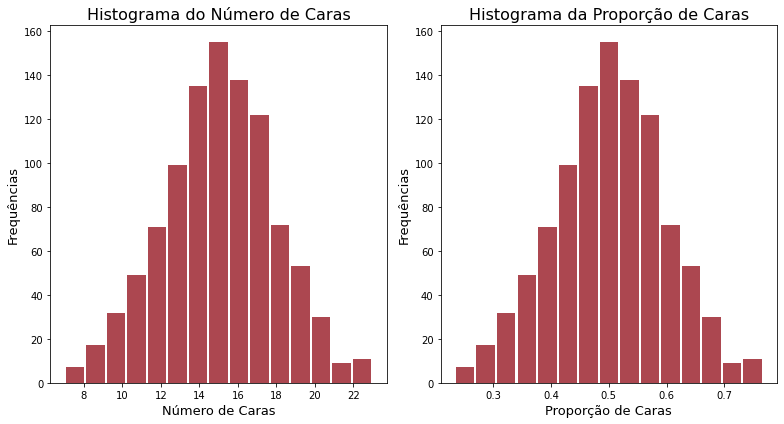

In [11]:
# definindo semente para reprodutibilidade
np.random.seed(13)

# criando 100k lançamentos meio a meio (moeda honesta)
pop_size = 10**5
data = np.zeros(pop_size)
data[:int(pop_size/2)] = 1 # número de caras

# definindo experimento - 1k experimentos com 30 amostras cada
size = 30
simulations = np.zeros(1000)
simulations1 = np.zeros(1000)
for i in range(1000):
  np.random.shuffle(data)
  tmp = data[:size]
  num_k = (tmp == 1).sum()
  prop = num_k/size
  simulations[i] = num_k
  simulations1[i] = prop

# histogramas dos resultados - contagem de caras e probabilidade
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

ax1.hist(simulations, color='#A3333D', alpha=0.9, density=False, bins=15, rwidth=0.9)
ax1.set_xlabel('Número de Caras', fontsize=13)
ax1.set_ylabel('Frequências', fontsize=13)
ax1.set_title('Histograma do Número de Caras', fontsize=16)

ax2.hist(simulations1, color='#A3333D', alpha=0.9, density=False, bins=15, rwidth=0.9)
ax2.set_xlabel('Proporção de Caras', fontsize=13)
ax2.set_ylabel('Frequências', fontsize=13)
ax2.set_title('Histograma da Proporção de Caras', fontsize=16)

fig.tight_layout()
plt.show()

In [12]:
alpha=0.05

count_inf = np.percentile(simulations, (alpha/2)*100).round(2)
count_sup = np.percentile(simulations, (1-alpha/2)*100).round(2)
print('COUNT INF: ', count_inf)
print('COUNT SUP: ', count_sup)

prop_inf = np.percentile(simulations1, (alpha/2)*100).round(2)
prop_sup = np.percentile(simulations1, (1-alpha/2)*100).round(2)
print('PROP INF:', prop_inf)
print('PROP SUP: ', prop_sup)


COUNT INF:  10.0
COUNT SUP:  20.0
PROP INF: 0.33
PROP SUP:  0.67


Note que se pegarmos 95% dos valores encontrados ao realizarmos 100k permutações, não estaremos incluindo casos com 23 caras e 7 coroas. Conclui-se que existem evidências que nos levam a rejeitar nossa hipótese nula de que a moeda é honesta a um nível de 5% de significância.

Isso não quer dizer que não possa acontecer de termos 23 caras e 7 coroas, ou vice-versa, apenas que é muito raro.

## Exercício 2

Você é o agente de um jogador da NBA que pretende receber o salário mais alto possível. Porém, apenas dois times estão interessados no jogador que você representa: Charlotte Hornets e Phoenix Suns. Ele notou que há uma diferença entre os dois times em relação ao salário médio e lhe pediu para checar se essa diferença pode ser explicada pelo acaso ou não.

Você utilizará o seguinte dataframe.

In [13]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/11-Hipoteses/nba_salaries.csv')
df.head()

# diferença dos salários médios
df[df['TEAM'].isin(['Charlotte Hornets', 'Phoenix Suns'])].groupby('TEAM').mean()

,SALARY
TEAM,
Charlotte Hornets,4.672355
Phoenix Suns,2.971813


**a)** Qual a estatística de teste?

In [14]:
data = df[df['TEAM'].isin(['Charlotte Hornets', 'Phoenix Suns'])]
def t_obs(data):
    result = data.groupby('TEAM').mean()
      # função deve retornar um valor apenas
    return result.iloc[1,0]-result.iloc[0,0]

In [15]:
result = t_obs(data)
assert_equal(round(result, 2), -1.70)

**b)** Agora responda ao jogador: Há diferença de salário significativa entre os clubes?

Utilize um nível de significância de 10%.

In [16]:
def resposta(data):
  # retorna True se a diferença puder ser explicada pelo acaso
  # retorna False se houver diferença significativa entre os salários
    df1 = data[data['TEAM']=='Charlotte Hornets']
    df2 = data[data['TEAM']=='Phoenix Suns']
    column = 'SALARY'
    size1 = len(df1)
    size2 = len(df2)
    n = 10000
    values_diff = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size1, replace=True, random_state = i)
        sample2 = df2[column].sample(size2,replace=True, random_state = i*3)
        values_diff[i] = sample1.mean() - sample2.mean()
        
    s = 50*alpha
    return np.percentile(values_diff,s) <= 0 <= np.percentile(values_diff, 100-s)

In [17]:
result = resposta(data)
assert_equal(result, True)

## P-valor e Significância

P-valor, ou valor-p, nada mais é do que a probabilidade de obter certo resultado de teste dada uma distribuição, ou seja, é a probabilidade do resultado ser o valor da estatística de teste.

Com o a estatística de teste encontramos uma probabilidade associada, o P-valor.

Já para significância o raciocínio é o oposto. Dado um nível de significância (probabilidade), encontramos o(s) valor(es) associado(s). Para um teste unilateral, teremos um valor e o nível de significância se mantém. Para um teste bilateral teremos dois valores e o nível de significância divide-se em dois. 


Veja o seguinte exemplo, com uma distribuição Normal de média 0 e variância 1.

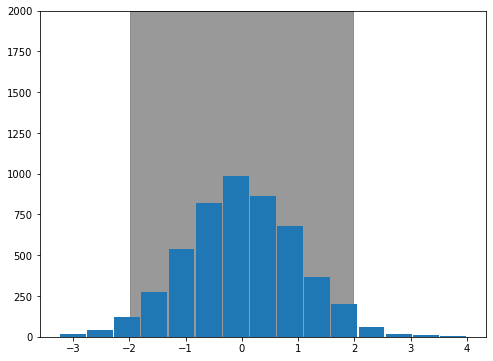

In [18]:
# Gerando 10k dados de uma distribuição normal
np.random.seed(16)
x = np.random.normal(0, 1, 5000)

# normalizando apenas para deixar mais simétrico
data = (x - x.mean()) / x.std()
plt.hist(data, bins=15, rwidth=0.95)

# calculando percentis para um intervalo de 95% de confiança (5% de significância)
li = np.percentile(data, 2.5)
ls = np.percentile(data, 97.5)

# plotando
plt.fill_between([li, ls], 4, 2000, color='grey', alpha=0.8)
plt.ylim(top=2000)
plt.show()

Os limites cinzas são definidos com base no percentil da distribuição. Encontramos esses pontos com base no nível de significância. Um nível de significância de 5% indica que a área cinza contém 95% dos dados enquanto a ára branca contém os demais 5%, sendo 2,5% para baixo e 2,5% para cima.

Quando o interesse for analisar apenas um lado da distribuição, devemos alterar o valor do percentil, como no código abaixo.

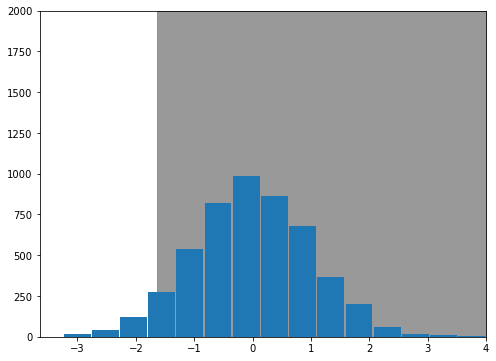

In [19]:
# normalizando apenas para deixar mais simétrico
data = (x - x.mean()) / x.std()
plt.hist(data, bins=15, rwidth=0.95)

# calculando percentis para um intervalo de 95% de confiança (5% de significância)
li = np.percentile(data, 5)

# plotando
plt.fill_between([li, 5], 4, 2000, color='grey', alpha=0.8)
plt.ylim(top=2000)
plt.xlim(right=4)
plt.show()

Nesse caso, temos 5% dos dados à esquerda e o restante a direita. Note que o nível de significância se manteve constante, porém o valor de corte se alterou.

## Exercício 3

Neste exercício iremos realizar todas as etapas de um teste de hipóteses. Utilizaremos teste de permutação, porém a metodologia é bem semelhante nos outros casos também, e nos ajuda a mantermos uma linha de raciocínio muito clara e objetiva.


**Exercício:** Utilizaremos um novo conjunto de dados da NBA. Desejamos testar se há uma diferença significativa na altura dos jogadores dos times Cleveland Cavaliers e Golden State Warriors na temporada 2017-18, a um nível de significância de 5%.

**Raciocínio:** 
- 1 - Definir as hipóteses nula e alternativa.
- 2 - Encontrar a estatística de teste.
- 3 - Resampling/Shuffle de acordo com a hipótese nula.
- 4 - Encontrar os valores crítios/calcular o p-valor.
- 5 - Concluir (rejeitar ou não a hipótese).

In [20]:
# preparação do dataset já está pronta
data = pd.read_csv('https://raw.githubusercontent.com/pedroharaujo/ICD_Docencia/master/all_seasons.csv', index_col=0)
df = data[(data['team_abbreviation'].isin(['GSW', 'CLE'])) & (data['season'] == '2017-18')]
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
9578,Draymond Green,GSW,28.0,200.66,104.326160,Michigan State,USA,2012,2,35,...,11.0,7.6,7.3,6.7,0.036,0.183,0.168,0.556,0.286,2017-18
9599,George Hill,CLE,32.0,190.50,85.275296,None,USA,2008,1,26,...,10.0,2.7,2.8,-3.3,0.023,0.081,0.161,0.580,0.145,2017-18
9667,Andre Iguodala,GSW,34.0,198.12,97.522280,Arizona,USA,2004,1,9,...,6.0,3.8,3.3,7.9,0.033,0.109,0.112,0.536,0.169,2017-18
9674,Ante Zizic,CLE,21.0,210.82,113.398000,None,Croatia,2016,1,23,...,3.7,1.9,0.2,-9.1,0.112,0.179,0.171,0.746,0.039,2017-18
9679,Cedi Osman,CLE,23.0,203.20,97.522280,None,Turkey,2015,2,31,...,3.9,2.0,0.7,3.9,0.028,0.149,0.151,0.577,0.084,2017-18


1 - Definir as hipóteses!

$$H_0: \mu_{CLE} = \mu_{GSW}$$

$$H_1: \mu_{CLE} \neq \mu_{GSW}$$

Ou ainda

$$H_0: \mu_{CLE} - \mu_{GSW} = 0$$

$$H_1: \mu_{CLE} - \mu_{GSW} \neq 0$$

Note que como estamos testando a hipótese alternativa como DIFERENTE, o teste é bilateral. Logo, deveremos dividir o nível de significância em duas regiões cada uma com metade do valor.

**2 - Encontre a estatística de teste**

Altere a função abaixo para que retorne a estatística de teste.

In [21]:
def t_obs2(data):
    # deve retornar o valor da estatística de teste
    medias = df.loc[:,['team_abbreviation','player_height']].groupby('team_abbreviation').mean()
    return medias.iloc[1,0]-medias.iloc[0,0]

In [22]:
result = t_obs2(df)
assert_equal(round(result, 2), 1.43)

3 - Resampling/Shuffle

Sempre de acordo com a hipótese nula! Ou seja, se estamos querendo testar se a média de pontos entre os times é igual, devemos remover o fator TIME da equação para podermos comparar.

Como já fizemos isso anteriormente, essa função já será dada aqui. Note que atribuímos uma semente diferente de acordo com o valor de $i$ no *loop*, de forma a deixar o experimento replicável.

In [23]:
def shuffling(data):
    N = 5000
    filtro = data['team_abbreviation'] == 'GSW'
    t_obs = data[filtro]['player_height'].mean() - data[~filtro]['player_height'].mean()
    diffs = np.zeros(N)
    for i in range(N):
        np.random.seed(i)
        np.random.shuffle(filtro.values)
        diffs[i] = data[filtro]['player_height'].mean() - data[~filtro]['player_height'].mean()
    return diffs

diffs = shuffling(df)

**4 - Encontrar valores críticos/Calcular o p-valor**

**a)** Altere a função abaixo para que calcule os valores críticos.

In [24]:
def critical_values(diffs):
    # deve retornar uma tupla com os valores criticos
    # exemplo: (critico_inferior, critico_superior)
    ci = np.percentile(diffs, 2.5)
    cs = np.percentile(diffs, 97.5)
    return (ci, cs)

In [25]:
(c_inf, c_sup) = critical_values(diffs)
assert_equal(round(c_inf, 2), -4.43)
assert_equal(round(c_sup, 2), 4.2)

**b)** Calcule o p-valor.

Lembrete: o p-valor consiste na área a cima (ou abaixo, a depender do sinal) da estatística de teste. Consiste na probabilidade de valores superiores (ou inferiores) ao da estatística de teste.

Altere a função abaixo para retornar o p-valor, com base na estatística de teste.

In [26]:
def p_value(t_obs, diffs):
    # deve retornar o p-valor ou seja,
    # a probabilidade de termos uma diferença maior que a estatística de teste
    aux = 0
    vetor = diffs > t_obs
    for i in vetor:
        if i == True:
            aux += 1
    pvalue = aux/len(diffs)
    return pvalue

In [27]:
result = t_obs2(df)
foo = p_value(result, diffs)
assert_equal(foo, 0.2654)

AssertionError: 
Items are not equal:
 ACTUAL: 0.271
 DESIRED: 0.2654

**5 - Conclusão**

Altere a função a seguir para retornar o resultado do teste. 

Retorne `True` caso rejeite a hipótese nula e `False` caso não rejeite.

In [28]:
def resposta2(diffs, t_obs):
    # voce pode escolher como quer fazer
    # pode ser com base no p-valor calculado
    # ou com base nos limites calculados e na estatística de teste
    # porém, sua entrada deve ser o vetor diffs e a estatística de teste calculados anteriormente
    li = np.percentile(diffs, 2.5)
    ls = np.percentile(diffs, 97.5)
    
    return not(li <= t_obs <= ls)

In [29]:
assert_equal(resposta2(diffs, result), False)